In [32]:
try:
    # Check if running in Google Colab
    import google.colab

    # Install required libraries
    !pip install shap numpy matplotlib pandas seaborn
    import shap
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns

except ImportError:
    # If not in Google Colab, import the libraries normally
    import shap
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns

# Now you can use the imported libraries
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import shap
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import joblib 
import seaborn as sns
import json
import time 
from utils.graphics import *
sns.set_style(rc=style_keys)
sns.set_context("notebook",rc=context_keys) 

TRAIN_DEFAULT_MODEL = False 
TRAIN_EXP_BAIRROS = False


In [33]:
try:
    # Check if running in Google Colab
    import google.colab
    from google.colab import drive

    # Mount Google Drive
    drive.mount('/content/drive', force_remount=True)

    # Define the path to your CSV file
    csv_file_path = '/content/drive/MyDrive/TCC/Projeto Imobiliário/data/dataset_florianopols.csv'

    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)

    # Drop specified columns
    df = df.drop(columns=['monthlyCondoFee', 'macroRegion'])

    # Drop columns with missing values
    df = df.dropna(axis=1)

    # Display the DataFrame
    print(df.head())

except ImportError:
    # If not in Google Colab, import pandas normally

    # Define the path to your CSV file
    csv_file_path = "data/dataset_florianopols.csv"

    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)

    # Drop specified columns
    df = df.drop(columns=['macroRegion'])

    # Drop columns with missing values
    df = df.dropna(axis=1)
    df

In [34]:
df.columns

Index(['usableAreas', 'parkingSpaces', 'suites', 'bathrooms', 'bedrooms',
       'price', 'neighborhood', 'GYM', 'BARBECUE_GRILL', 'PARTY_HALL', 'POOL',
       'PLAYGROUND', 'GARDEN', 'GOURMET_SPACE', 'DINNER_ROOM', 'BACKYARD',
       'SPORTS_COURT', 'SPA', 'GAMES_ROOM', 'BARBECUE_BALCONY',
       'RECREATION_AREA', 'SAUNA', 'GRASS', 'CINEMA', 'COWORKING',
       'TENNIS_COURT', 'ELEVATOR', 'CONCIERGE_24H', 'SECURITY_24_HOURS'],
      dtype='object')

In [35]:
df.shape

(45365, 29)

In [4]:
# Convert binary variables to 0 and 1
binary_variables = ['GYM', 'BARBECUE_GRILL', 'PARTY_HALL', 'POOL',
       'PLAYGROUND', 'GARDEN', 'GOURMET_SPACE', 'DINNER_ROOM', 'BACKYARD',
       'SPORTS_COURT', 'SPA', 'GAMES_ROOM', 'BARBECUE_BALCONY',
       'RECREATION_AREA', 'SAUNA', 'GRASS', 'CINEMA', 'COWORKING',
       'TENNIS_COURT', 'ELEVATOR', 'CONCIERGE_24H', 'SECURITY_24_HOURS']

df[binary_variables] = df[binary_variables].astype('int')

In [5]:
""" X_corr = df.drop(["neighborhood"], axis=1) # Independent variables

corr = X_corr.corr(method='pearson')
# Plotando a matriz de correlação
plt.figure(figsize=(30, 30))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 20})
plt.title('Matriz de Correlação', fontweight='bold', loc='left', y=ALTURA_TITULO)  # Adjust y parameter to add space

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig(os.path.join('graphics', "correlation_matrix.png"))
plt.savefig(os.path.join('graphics', "correlation_matrix.pdf"))

plt.show() """

' X_corr = df.drop(["neighborhood"], axis=1) # Independent variables\n\ncorr = X_corr.corr(method=\'pearson\')\n# Plotando a matriz de correlação\nplt.figure(figsize=(30, 30))\nsns.heatmap(corr, annot=True, cmap=\'coolwarm\', fmt=".2f", annot_kws={"size": 20})\nplt.title(\'Matriz de Correlação\', fontweight=\'bold\', loc=\'left\', y=ALTURA_TITULO)  # Adjust y parameter to add space\n\nplt.xticks(rotation=45, ha=\'right\')\nplt.yticks(rotation=0)\nplt.tight_layout()\n\nplt.savefig(os.path.join(\'graphics\', "correlation_matrix.png"))\nplt.savefig(os.path.join(\'graphics\', "correlation_matrix.pdf"))\n\nplt.show() '

In [6]:
def train_evaluate_model(
        model,
        model_name,
        dataframe, 
        directory_path,
        neighborhood=None,
        columns_to_drop=['neighborhood'],
        random_sample_size=None

        ):
    
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    dataframe = dataframe[dataframe['neighborhood'] == neighborhood] if neighborhood is not None else dataframe
    # Optionally select a random sample of the data
    if random_sample_size is not None:
        dataframe = dataframe.sample(frac=random_sample_size)
    X = dataframe.drop("price", axis=1)
    y = dataframe['price']
    print(dataframe.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=X['neighborhood'])
    plot_neighborhood_distribution(X_train, X_test, directory_path)

    neighborhood_indices = {}
    for neighborhood in X_train['neighborhood'].unique():
        neighborhood_indices[neighborhood] = X_test[X_test['neighborhood'] == neighborhood].index.tolist()

    X_train = X_train.drop(columns=columns_to_drop)
    X_test = X_test.drop(columns=columns_to_drop)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    plot_predicted_vs_real(y_pred, y_test, model_name, directory_path)

    shap_importance_plot(model, X_train, model_name, directory_path)

    save_model(model, model_name, directory_path)

    generate_neighborhood_results(model, X_test, y_test, neighborhood_indices, model_name, directory_path)

    results = [[model_name, rmse, r2, mape]]
    return results


def plot_predicted_vs_real(y_pred, y_test, model_name, directory_path, figsize=(30,20)):
    sns.set_style(style="whitegrid",  rc=style_keys)
    sns.set_context("notebook",rc=context_keys) 
    
    plt.figure(figsize=figsize)
    identity_line = [min(y_pred), max(y_pred)]
    plt.plot(identity_line, identity_line, color='black')
    sns.scatterplot(x=y_pred, y=y_test, s=10, color=PALLETE[1])  # Setting points to a darker color
    
    plt.xlabel("Valor predito ($)", labelpad=PAD_SIZE)
    plt.ylabel("Valor real ($)", labelpad=PAD_SIZE)
    plt.title(f"Valor Predito vs Valor Real - {model_name}", fontweight='bold', loc='left', y=TITLE_PAD)  # Adjust y parameter to add space

    plt.tight_layout()
    
    plt.savefig(os.path.join(directory_path, f"{model_name}_predicted_vs_real.png"))
    plt.savefig(os.path.join(directory_path, f"{model_name}_predicted_vs_real.pdf"))
    
    plt.close()

def shap_importance_plot(model, X_train, model_name, directory_path):
    sns.set_style(style="whitegrid",  rc=style_keys)
    sns.set_context("notebook",rc=context_keys) 

    if isinstance(model, Lasso):
        explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
    else:
        explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)

    feature_names = X_train.columns
    shap_importance = pd.DataFrame(shap_values, columns=feature_names)
    vals = np.abs(shap_importance.values).mean(0)
    shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name', 'feature_importance_vals'])
    shap_importance.set_index("col_name", inplace=True)
    sum_values = shap_importance["feature_importance_vals"].sum()
    shap_importance['feature_importance_vals'] = shap_importance['feature_importance_vals'] / sum_values * 100
    shap_importance_sorted = shap_importance.sort_values(by='feature_importance_vals', ascending=False)

    plt.figure(figsize=(30, 20))
    sns.barplot(x='feature_importance_vals', y=shap_importance_sorted.index, data=shap_importance_sorted, color=COR_AZUL)
    plt.xlabel('Importância da Variável (%)', labelpad=PAD_SIZE)
    plt.ylabel('Variável', labelpad=PAD_SIZE)
    plt.title(f"Variáveis críticas para predição do modelo - {model_name}", fontweight='bold', loc='left', y=TITLE_PAD)  # Adjust y parameter to add space
    plt.tight_layout()
    
    for index, value in enumerate(shap_importance_sorted['feature_importance_vals']):
        plt.text(value + 0.05, index, f'{value:.2f}%', va='center')

    plt.savefig(os.path.join(directory_path, f"{model_name}_shap_importance_plot.png"), dpi=DPI)
    plt.savefig(os.path.join(directory_path, f"{model_name}_shap_importance_plot.pdf"), dpi=DPI)
    
    plt.close()

def save_model(model, model_name, directory_path):
    joblib.dump(model, f"{directory_path}/{model_name}_best_model.pkl")

def generate_neighborhood_results(model, X_test, y_test, neighborhood_indices, model_name, directory_path):
    results_by_neighborhood = {}

    for neighborhood, indices in neighborhood_indices.items():
        y_pred_neighborhood = model.predict(X_test[X_test.index.isin(indices)])
        y_test_neighborhood = y_test[X_test.index.isin(indices)]

        rmse_neighborhood = np.sqrt(mean_squared_error(y_test_neighborhood, y_pred_neighborhood))
        r2_neighborhood = r2_score(y_test_neighborhood, y_pred_neighborhood)
        mape_neighborhood = np.mean(np.abs((y_test_neighborhood - y_pred_neighborhood) / y_test_neighborhood)) * 100
        num_observations = len(y_test_neighborhood)

        neighborhood_result = {
            'R²': r2_neighborhood,
            'RMSE': rmse_neighborhood,
            'MAPE': mape_neighborhood,
            'Predicted_Values': y_pred_neighborhood.tolist(),
            'True_Values': y_test_neighborhood.tolist(),
            'Observations': num_observations
        }

        results_by_neighborhood[neighborhood] = neighborhood_result

    neighborhood_results_df = pd.DataFrame(results_by_neighborhood).T.reset_index()
    neighborhood_results_df.rename(columns={'index': 'Neighborhood'}, inplace=True)
    neighborhood_results_df = neighborhood_results_df[['Neighborhood', 'R²', 'RMSE', 'MAPE']]

    num_observations = [len(results['True_Values']) for results in results_by_neighborhood.values()]
    neighborhood_results_df['Observations'] = num_observations

    neighborhood_results_df_sorted = neighborhood_results_df.sort_values(by='Observations', ascending=False)
    neighborhood_results_df_sorted.reset_index(drop=True, inplace=True)
    neighborhood_results_df_sorted.to_csv(os.path.join(directory_path, f'{model_name}_bairros.csv'), index=False)

def plot_neighborhood_distribution(X_train, X_test, directory_path):
    sns.set_style(style="whitegrid",  rc=style_keys)
    sns.set_context("notebook",rc=context_keys) 

    train_neighborhood_counts = X_train['neighborhood'].value_counts()
    test_neighborhood_counts = X_test['neighborhood'].value_counts()
    df = pd.DataFrame({'Treino': train_neighborhood_counts, 'Teste': test_neighborhood_counts})

    df = df.fillna(0) 
    df['Total'] = df['Treino'] + df['Teste']
    df = df.sort_values(by='Total', ascending=False)
    df.drop('Total', axis=1, inplace=True)

    plt.figure(figsize=(35, 30))
    sns.barplot(x='Treino', y=df.index, data=df, color=COR_AZUL, label='Train', errorbar=None)
    sns.barplot(x='Teste', y=df.index, data=df, color=COR_LARANJA, label='Test', errorbar=None)

 
    plt.title('Distribuição dos bairros após estratificação', fontweight='bold', loc='left', y=TITLE_PAD)  # Adjust y parameter to add space

    plt.xlabel('Número de Observações', labelpad=PAD_SIZE)
    plt.ylabel('Bairro', labelpad=PAD_SIZE)
    plt.legend(title='Dados')
    
    # Save the plot as PNG and PDF
    plt.tight_layout()
    plt.savefig(os.path.join(directory_path, "neighborhood_distribution.png"), dpi=DPI)
    plt.savefig(os.path.join(directory_path, "neighborhood_distribution.pdf"), dpi=DPI)
    # Close the figure
    plt.close()


def save_results(results, directory_path):
    results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'R²', 'MAPE'])
    results_df.to_csv(os.path.join(directory_path, 'models_result.csv'), index=False)


In [7]:
dir_path = 'model_default'

models = {
    'Random Forest': RandomForestRegressor(max_depth=8, random_state=42, n_estimators=200, max_features=9),
    'XGBoost': XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, random_state=42),
    'Lasso Regression': Lasso(alpha=0.1, random_state=42)
}
# Define model parameters and experiment conditions
model_parameters = {
    "experiment_conditions": {
        "dataset": "models_teste",
        "description": "Basic model with all the columns and volume"
    },
    "models": {
        "Random Forest": {
            "max_depth": 8,
            "n_estimators": 200,
            "max_features": 9
        },
        "XGBoost": {
            "n_estimators": 1000,
            "max_depth": 7,
            "eta": 0.1,
            "subsample": 0.7,
            "colsample_bytree": 0.8
        },
        "Lasso Regression": {
            "alpha": 0.1
        }
    }
}
if TRAIN_DEFAULT_MODEL: 
    training_results = []
    for model_name, model in models.items():
        model_results = train_evaluate_model(
            model=model, 
            model_name=model_name, 
            dataframe=df, 
            directory_path=dir_path,
            neighborhood=None, 
        )
        training_results.extend(model_results)

    save_results(training_results, dir_path)

    with open(f"{dir_path}/model_parameters.json", "w") as json_file:
        json.dump(model_parameters, json_file, indent=4)

## Otimização de hiperparâmetros


### XGboost
- max_depth:
- learning_rate

### Random Forest
- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)
### Lasso
-
- selection: If set to ‘random’, a random coefficient is updated every iteration rather than looping over features sequentially by default. This (setting to ‘random’) often leads to significantly faster convergence especially when tol is higher than 1e-4.



In [8]:
""" import os
import json
import pandas as pd
from time import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from scipy import stats
import joblib 



def save_results_to_json(results, directory_path):
    for model_name, result in results.items():
        file_path = f"{directory_path}/{model_name}_results.json"
        with open(file_path, 'w') as f:
            json.dump(result, f)

def find_best_model_using_gridsearch(
        dataframe, 
        directory_path,
        neighborhood='Centro',
        columns_to_drop=['neighborhood']
    ):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    dataframe = dataframe[dataframe['neighborhood'] == neighborhood] if neighborhood is not None else dataframe
    print(f'Datraframe format: {dataframe.shape}')
    X = dataframe.drop("price", axis=1)
    y = dataframe['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=X['neighborhood'])
   
    neighborhood_indices = {}
    for neighborhood in X_train['neighborhood'].unique():
        neighborhood_indices[neighborhood] = X_test[X_test['neighborhood'] == neighborhood].index.tolist()

    X_train = X_train.drop(columns=columns_to_drop)
    X_test = X_test.drop(columns=columns_to_drop)

    hyperparameters = {
        "RandomForestRegressor": {
            "model": RandomForestRegressor(),
            "parameters": {
                "n_estimators": [int(x) for x in np.linspace(start=200, stop=500, num=50)],
                "max_depth": [int(x) for x in np.linspace(start=2, stop=18, num=2)],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4],
                "max_features": [5, 7, 9],
                "bootstrap": [True, False]
            }
        },
        "XGBRegressor": {
            "model": XGBRegressor(),
            "parameters": {
                "objective": ['reg:linear'],
                "n_estimators": [int(x) for x in np.linspace(start=200, stop=500, num=50)],
                "max_depth": [int(x) for x in np.linspace(start=2, stop=18, num=2)],
                "min_child_weight": [2,3,4],
                "learning_rate": [0.045, 0.05, 0.06],
                "subsample": [0.5, 0.55, 0.85],
                "colsample_bytree": [0.6, 0.8, 1.0],
                "gamma": [0, 0.001, 0.01, 0.1, 0.2],
                "reg_alpha": [0, 0.5, 1],
                "reg_lambda": [0, 0.5, 1]
            }
        },
        "Lasso": {
            "model": Lasso(),
            "parameters": {
                "alpha":  stats.loguniform(1e-2, 1e0),
                "selection": ["cyclic", "random"]
            }
        }
    }
    scores = {}
    results = {}  # Store results for each hyperparameter

    for algo_name, config in hyperparameters.items():
        random_search = RandomizedSearchCV(
                            estimator=config["model"],
                            param_distributions=config["parameters"],
                            n_iter=100,
                            cv=10,
                            verbose=5,
                            random_state=42,
                            n_jobs=-1,
                        )
        start = time()
        random_search.fit(X_train, y_train)
        print(
            "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
            % ((time() - start), 100)
        )
        best_model = random_search.best_estimator_
        best_score = random_search.best_score_
        best_params = random_search.best_params_
        scores[algo_name] = {
            "best_score": best_score,
            "best_params": best_params
        }
        results[algo_name] = {
            "params": random_search.cv_results_['params'],
            "mean_test_score": random_search.cv_results_['mean_test_score'].tolist()  # Convert NumPy array to list
        }

        joblib.dump(best_model, f"{directory_path}/{algo_name}_best_model.pkl")
    
    save_results_to_json(results, directory_path)

    best_score_path = os.path.join(directory_path, "best_model_results.json")
    with open(best_score_path, 'w') as f:
        json.dump(scores, f)
    return scores
directory_path = ''

df_scores = find_best_model_using_gridsearch(dataframe=df,
                                             directory_path='models_cv_all_vizinhos',
                                             neighborhood=None,)
df_scores """

' import os\nimport json\nimport pandas as pd\nfrom time import time\nfrom sklearn.model_selection import train_test_split, RandomizedSearchCV\nfrom sklearn.ensemble import RandomForestRegressor\nfrom xgboost import XGBRegressor\nfrom sklearn.linear_model import Lasso\nfrom scipy import stats\nimport joblib \n\n\n\ndef save_results_to_json(results, directory_path):\n    for model_name, result in results.items():\n        file_path = f"{directory_path}/{model_name}_results.json"\n        with open(file_path, \'w\') as f:\n            json.dump(result, f)\n\ndef find_best_model_using_gridsearch(\n        dataframe, \n        directory_path,\n        neighborhood=\'Centro\',\n        columns_to_drop=[\'neighborhood\']\n    ):\n    if not os.path.exists(directory_path):\n        os.makedirs(directory_path)\n\n    dataframe = dataframe[dataframe[\'neighborhood\'] == neighborhood] if neighborhood is not None else dataframe\n    print(f\'Datraframe format: {dataframe.shape}\')\n    X = datafr

## Criando os experimentos 

### 1) 10 bairros mais populosos.

In [9]:
df_bairros = pd.read_csv('experiments\Todos\XGBoost_bairros.csv')

# Sort the DataFrame by 'Observations' column in descending order
df_bairros_sorted = df_bairros.sort_values(by='Observations', ascending=False)

# Get the top 10 neighborhoods
top_10_bairos = df_bairros_sorted.head(10)

print("Top 10 neighborhoods with the most number of observations:")
print(top_10_bairos)
# Get the indices of the top 10 neighborhoods
bairros_exp_observations = df_bairros_sorted.head(10)['Neighborhood'].tolist()

print("Indices of the top 10 neighborhoods with the most number of observations:")
print(bairros_exp_observations)


Top 10 neighborhoods with the most number of observations:
               Neighborhood        R²           RMSE       MAPE  Observations
0  Ingleses do Rio Vermelho  0.483975  379103.602977  39.218594          1810
1                    Centro  0.725935  381418.566571  18.066856          1660
2                  Campeche  0.535975  411252.206712  20.282787          1124
3                 Itacorubi  0.817814  245732.083661  14.727278           875
4                Agronômica  0.619253  411944.920075  17.637720           610
5                  Trindade  0.765887  266773.798646  17.644615           508
6                 Coqueiros  0.729819  318148.860796  21.360591           416
7                     Canto  0.531207  264936.300012  20.900441           409
8                João Paulo  0.800693  313115.061312  15.635935           408
9                 Capoeiras -0.220965  357169.105621  35.106630           404
Indices of the top 10 neighborhoods with the most number of observations:
['Inglese

In [22]:
bairros_exp_observations

['Ingleses do Rio Vermelho',
 'Centro',
 'Campeche',
 'Itacorubi',
 'Agronômica',
 'Trindade',
 'Coqueiros',
 'Canto',
 'João Paulo',
 'Capoeiras']

In [10]:
# List to store experiment details
exp_bairros_isolados = []

# Iterate over each neighborhood
for bairro in bairros_exp_observations:

    # Create experiment dictionary
    experiment = {
        'dir_path': f'experiments/bairro_isolado/{bairro}',
        'neighborhood': bairro,
        'columns_to_drop': ['neighborhood'],
        'random_sample_size': 1
    }
    # Append experiment dictionary to the list
    exp_bairros_isolados.append(experiment)

In [11]:
for experiment in exp_bairros_isolados:
    dir_path = experiment['dir_path']
    neighborhood = experiment['neighborhood']
    columns_to_drop = experiment['columns_to_drop']
    random_sample_size = experiment['random_sample_size']
    # Create directory if it doesn't exist
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    training_results = []
    if TRAIN_EXP_BAIRROS: 
        # Train and evaluate the model for the current experiment
        model_results = train_evaluate_model(
            model=XGBRegressor(n_estimators=248,
                            subsample=0.55, 
                            reg_lambda=1, 
                            reg_alpha=1, 
                            min_child_weight=4, 
                            max_depth=18,
                            learning_rate=0.045, 
                            gamma=0.01, 
                            colsample_bytree=0.6, 
                            #eta=0.1,
                            random_state=42), 
            model_name='XGBoost', 
            dataframe=df, 
            directory_path=dir_path,
            neighborhood=neighborhood, 
            columns_to_drop=columns_to_drop,
            random_sample_size=random_sample_size, 
        )

        training_results.extend(model_results)

        save_results(training_results, dir_path) 

### 2) Treinando com Um terço dos dados 

In [12]:
# List to store experiment details
exp_bairros_um_terco = []

# Iterate over each neighborhood
for bairro_idx, bairro in enumerate(bairros_exp_observations):
    # Create three experiments for each neighborhood
    for i in range(3):
        # Create experiment dictionary
        experiment = {
            'dir_path': f'experiments/um_terco/{bairro}_{i}',
            'neighborhood': bairro,
            'columns_to_drop': ['neighborhood'],
            'random_sample_size': 0.33
        }
        # Append experiment dictionary to the list
        exp_bairros_um_terco.append(experiment)

In [13]:
for experiment in exp_bairros_um_terco:
    dir_path = experiment['dir_path']
    neighborhood = experiment['neighborhood']
    columns_to_drop = experiment['columns_to_drop']
    random_sample_size = experiment['random_sample_size']
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    training_results = []
    if TRAIN_EXP_BAIRROS: 
        print('Training EXP Bairros um terço')
        # Train and evaluate the model for the current experiment
        model_results = train_evaluate_model(
            model=XGBRegressor(n_estimators=248,
                            subsample=0.55, 
                            reg_lambda=1, 
                            reg_alpha=1, 
                            min_child_weight=4, 
                            max_depth=18,
                            learning_rate=0.045, 
                            gamma=0.01, 
                            colsample_bytree=0.6, 
                            #eta=0.1,
                            random_state=42), 
            model_name='XGBoost', 
            dataframe=df, 
            directory_path=dir_path,
            neighborhood=neighborhood, 
            columns_to_drop=columns_to_drop,
            random_sample_size=random_sample_size, 
        )

        training_results.extend(model_results)

        save_results(training_results, dir_path) 

### 3) Experimento com amenidades

In [14]:
exp_diff_features = [
    {
        'dir_path': 'experiments/diff_features/Amenidades',
        'neighborhood': None, 
        'columns_to_drop': ['neighborhood', 'usableAreas', 'parkingSpaces', 'suites', 'bathrooms', 'bedrooms'],
        'random_sample_size': 1, 
    },
    {
        'dir_path': 'experiments/diff_features/Todos',
        'neighborhood': None, 
        'columns_to_drop': ['neighborhood'],
        'random_sample_size': 1, 
    },
    {
        'dir_path': 'experiments/diff_features/Área_com_amenidades',
        'neighborhood': None, 
        'columns_to_drop': ['neighborhood', 'parkingSpaces', 'suites', 'bathrooms', 'bedrooms'],
        'random_sample_size': 1, 
    },
    {
        'dir_path': 'experiments/diff_features/Garagem_com_amenidades',
        'neighborhood': None, 
        'columns_to_drop': ['neighborhood', 'usableAreas',  'suites', 'bathrooms', 'bedrooms'],
        'random_sample_size': 1, 
    },
    {
        'dir_path': 'experiments/diff_features/Suits_com_amenidades',
        'neighborhood': None, 
        'columns_to_drop': ['neighborhood', 'usableAreas', 'parkingSpaces', 'bathrooms', 'bedrooms'],
        'random_sample_size': 1,
    },
    {
        'dir_path': 'experiments/diff_features/Banheiro_com_amenidades',
        'neighborhood': None, 
        'columns_to_drop': ['neighborhood', 'usableAreas', 'parkingSpaces', 'suites', 'bedrooms'],
        'random_sample_size': 1, 
    },
    {
        'dir_path': 'experiments/diff_features/Quartos_com_amenidades',
        'neighborhood': None, 
        'columns_to_drop': ['neighborhood', 'usableAreas', 'parkingSpaces', 'suites', 'bathrooms'],
        'random_sample_size': 1, 
    },
    {
        'dir_path': 'experiments/diff_features/Todos_um_terço',
        'neighborhood': None, 
        'columns_to_drop': ['neighborhood'],
        'random_sample_size': 0.33, 
    },
 ]

In [15]:

# Iterate over each experiment
for experiment in exp_diff_features:
    dir_path = experiment['dir_path']
    neighborhood = experiment['neighborhood']
    columns_to_drop = experiment['columns_to_drop']
    random_sample_size = experiment['random_sample_size']
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    training_results = []
    if TRAIN_EXP_BAIRROS: 
        # Train and evaluate the model for the current experiment
        model_results = train_evaluate_model(
            model=XGBRegressor(n_estimators=248,
                            subsample=0.55, 
                            reg_lambda=1, 
                            reg_alpha=1, 
                            min_child_weight=4, 
                            max_depth=18,
                            learning_rate=0.045, 
                            gamma=0.01, 
                            colsample_bytree=0.6, 
                            #eta=0.1,
                            random_state=42), 
            model_name='XGBoost', 
            dataframe=df, 
            directory_path=dir_path,
            neighborhood=neighborhood, 
            columns_to_drop=columns_to_drop,
            random_sample_size=random_sample_size, 
        )

        training_results.extend(model_results)

        save_results(training_results, dir_path) 

### Modelo Bairro isolado

In [16]:
# Define the directory path
dir_path = 'experiments/bairro_isolado'

# Initialize an empty DataFrame to store the results
df_bairros_isolado = pd.DataFrame(columns=['RMSE', 'R²', 'MAPE'])

# Iterate over each folder in the directory
for folder in os.listdir(dir_path):
    folder_path = os.path.join(dir_path, folder)
    if os.path.isdir(folder_path):
        # Read the models_result.csv file
        csv_path = os.path.join(folder_path, 'models_result.csv')
        if os.path.exists(csv_path):
            # Read CSV and extract relevant columns
            df = pd.read_csv(csv_path)
            df = df[['RMSE', 'R²', 'MAPE']]
            # Set folder name as index
            df.index = [folder] * len(df)
            # Append the data to the results DataFrame
            df_bairros_isolado = pd.concat([df_bairros_isolado, df])

# Print the DataFrame
df_bairros_isolado

C:\Users\yurib\AppData\Local\Temp\ipykernel_7348\488919924.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_bairros_isolado = pd.concat([df_bairros_isolado, df])


,RMSE,R²,MAPE
Ingleses do Rio Vermelho,295071.794746,0.702258,22.008655
Centro,307102.637374,0.815007,15.627064
Campeche,343807.439217,0.700819,17.687540
Itacorubi,197532.167386,0.889924,10.505879
Agronômica,298066.616034,0.822880,12.113443
Trindade,177065.806880,0.895085,11.750957
Coqueiros,161445.204938,0.916004,11.128701
Canto,167587.431226,0.834511,11.291193
João Paulo,260443.857567,0.879775,11.463867
Capoeiras,145908.029942,0.810860,11.252750


### Modelo um terço dos dados

In [17]:
# Define the directory path
dir_path = 'experiments/um_terco'

# Initialize an empty DataFrame to store the results
df_bairros_um_terco = pd.DataFrame(columns=['RMSE', 'R²', 'MAPE'])

# Iterate over each folder in the directory
for folder in os.listdir(dir_path):
    folder_path = os.path.join(dir_path, folder)
    if os.path.isdir(folder_path):
        # Read the models_result.csv file
        csv_path = os.path.join(folder_path, 'models_result.csv')
        if os.path.exists(csv_path):
            # Read CSV and extract relevant columns
            df = pd.read_csv(csv_path)
            df = df[['RMSE', 'R²', 'MAPE']]
            # Set folder name as index
            df.index = [folder] * len(df)
            # Append the data to the results DataFrame
            df_bairros_um_terco = pd.concat([df_bairros_um_terco, df])

# Group the DataFrame by the starting substring of the index
grouped_df = df_bairros_um_terco.groupby(df_bairros_um_terco.index.str.split('_').str[0])

# Calculate the mean for each group
df_bairros_um_terco_media = grouped_df.mean()
df_bairros_um_terco_media

C:\Users\yurib\AppData\Local\Temp\ipykernel_7348\638938286.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_bairros_um_terco = pd.concat([df_bairros_um_terco, df])


,RMSE,R²,MAPE
Agronômica,394248.303772,0.702591,17.950012
Campeche,372501.960054,0.645940,20.872330
Canto,190675.253781,0.768569,13.576130
Capoeiras,151614.921001,0.785760,13.486794
Centro,382808.660805,0.718967,20.143629
Coqueiros,220476.008111,0.857862,13.903749
Ingleses do Rio Vermelho,325649.051962,0.666422,24.742630
Itacorubi,241074.053620,0.835011,12.672273
João Paulo,348051.041911,0.794954,15.726476
Trindade,250735.741165,0.813308,16.088780


### Modelo geral

In [25]:
df_todos = pd.read_csv('experiments\diff_features\Todos\XGBoost_bairros.csv')
# Set 'Neighborhood' as the index
df_todos.set_index('Neighborhood', inplace=True)
# Classify the df_todosFrame by number of observations
sorted_df_todos = df_todos.sort_values(by='Observations', ascending=False)
sorted_df_todos

,R²,RMSE,MAPE,Observations
Neighborhood,,,,
Ingleses do Rio Vermelho,0.476041,399598.621502,38.630766,1775
Centro,0.709546,398558.996677,18.854909,1756
Campeche,0.471447,460092.146937,21.812749,1226
Itacorubi,0.807036,252900.819695,14.974769,874
Agronômica,0.650345,436443.379571,18.113716,649
Trindade,0.778999,262781.625364,18.519814,506
João Paulo,0.753922,367041.061597,17.036730,430
Coqueiros,0.785590,285738.279893,21.620382,410
Canto,0.589419,289004.646388,21.958491,407


In [27]:
bairros_exp_observations

# Select the top 10 neighborhoods with most observations
df_todos_top_10 = sorted_df_todos
# Create a new DataFrame using only the index inside `bairros_exp_observations`
df_todos_top_10 = df_todos_top_10.loc[bairros_exp_observations]
df_todos_top_10

,R²,RMSE,MAPE,Observations
Neighborhood,,,,
Ingleses do Rio Vermelho,0.476041,399598.621502,38.630766,1775
Centro,0.709546,398558.996677,18.854909,1756
Campeche,0.471447,460092.146937,21.812749,1226
Itacorubi,0.807036,252900.819695,14.974769,874
Agronômica,0.650345,436443.379571,18.113716,649
Trindade,0.778999,262781.625364,18.519814,506
Coqueiros,0.785590,285738.279893,21.620382,410
Canto,0.589419,289004.646388,21.958491,407
João Paulo,0.753922,367041.061597,17.036730,430


## Comparação entre modelo generalista x modelo isolado

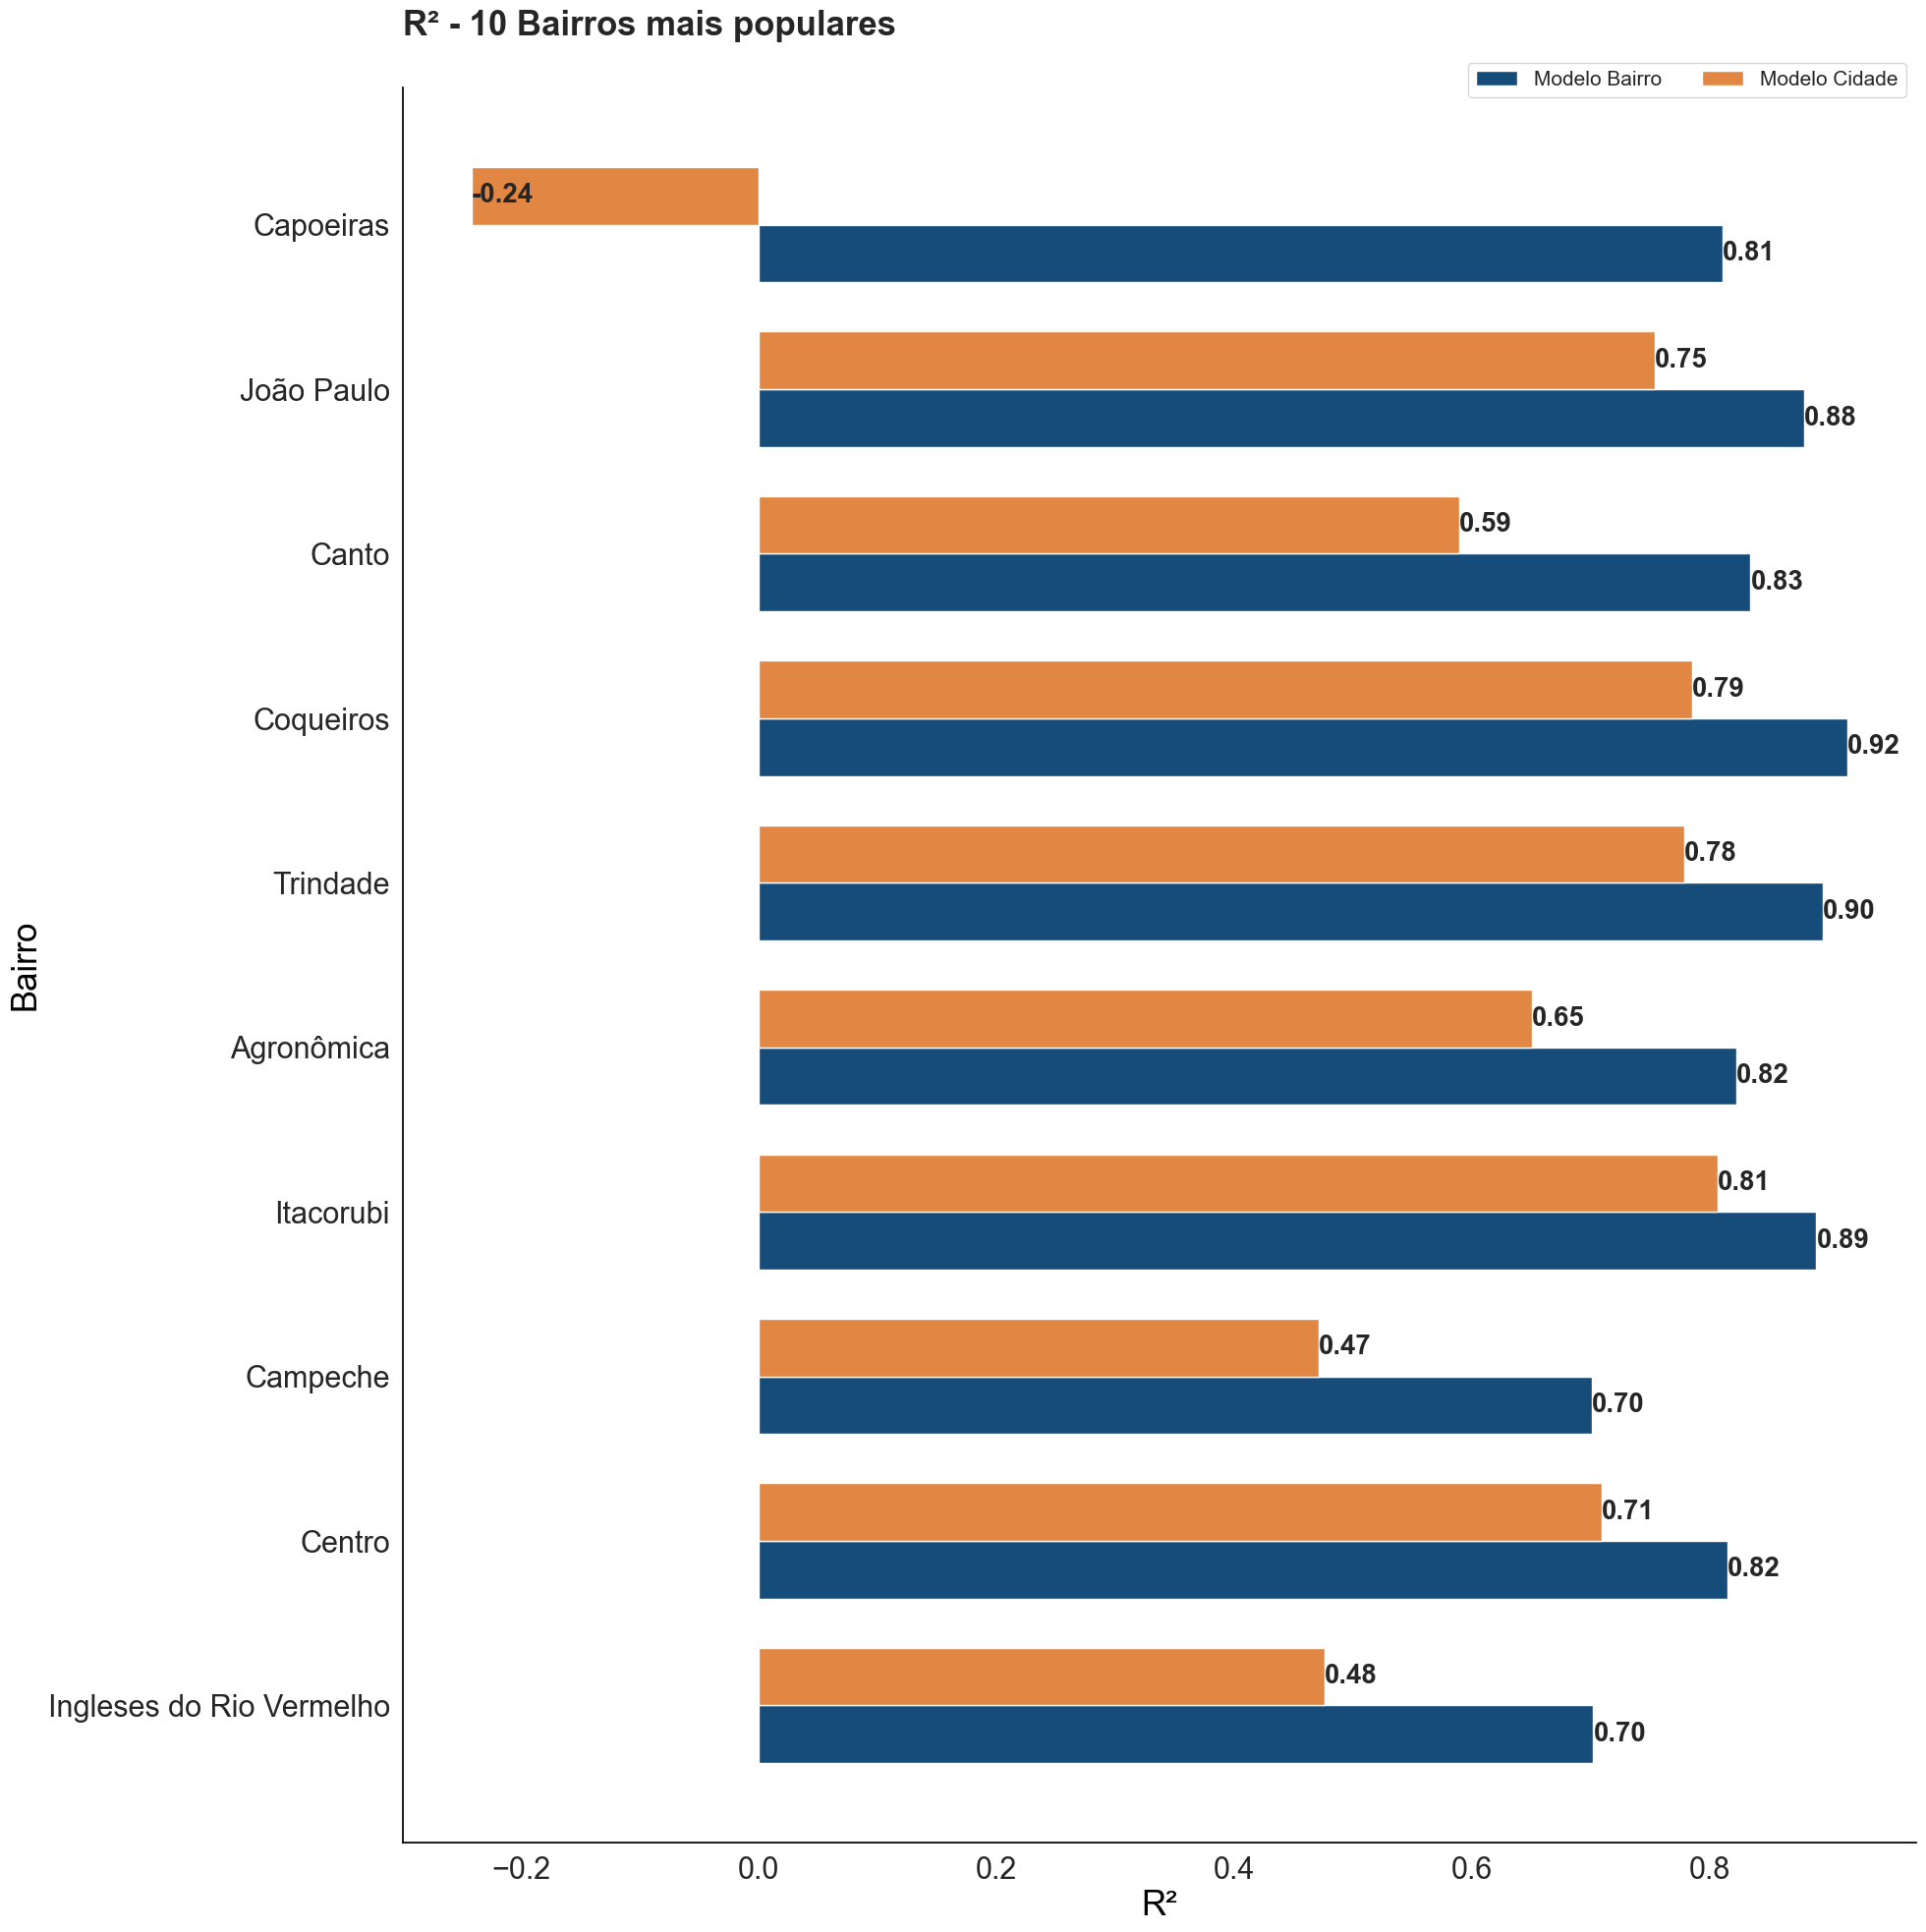

In [28]:
sns.set_style("whitegrid", rc=style_keys)
sns.set_context("notebook", rc=context_keys)

# Get the neighborhoods and their corresponding index
neighborhoods = df_todos_top_10.index
index = np.arange(len(neighborhoods))
# Define the width of each bar
bar_width = 0.35

# Create the grouped horizontal bar chart
plt.figure(figsize=(20, 20))  # Adjust figure size as needed
# Plot bars for 'apartment' category
bars_isolado = plt.barh(index - bar_width, df_bairros_isolado['R²'], bar_width, label='Modelo Bairro', color=PALLETE[0])

# Plot bars for 'house' category
bars_todos = plt.barh(index, df_todos_top_10['R²'], bar_width, label='Modelo Cidade', color=PALLETE[1])

# Set labels and title
plt.xlabel('R²')
plt.ylabel('Bairro')
plt.title('R² - 10 Bairros mais populares', fontweight='bold', loc='left', y=TITLE_PAD)
plt.yticks(index - bar_width/2, neighborhoods)

# Add price values outside each bar for 'apartment' category
for i, bar_apartment in enumerate(bars_isolado):
    price_apartment = df_bairros_isolado.iloc[i]['R²']
    plt.text(price_apartment, i - bar_width, f'{price_apartment:.2f}', va='center', ha='left', fontweight='bold')

# Add price values outside each bar for 'house' category
for i, bar_house in enumerate(bars_todos):
    price_house =df_todos_top_10.iloc[i]['R²']
    plt.text(price_house, i, f'{price_house:.2f}', va='center', ha='left', fontweight='bold')

plt.legend(
    loc='upper right',
    bbox_to_anchor=(1, 1.02),
    fancybox=True,
    shadow=False,
    ncol=2
    )

os.makedirs('graphics', exist_ok=True)
plt.savefig(os.path.join('graphics', f'r2_top10_bairros.png'), bbox_inches='tight', facecolor='white')
plt.savefig(os.path.join('graphics', f'r2_top10_bairros.pdf'), bbox_inches='tight', facecolor='white')

plt.tight_layout()
plt.show()
plt.close()

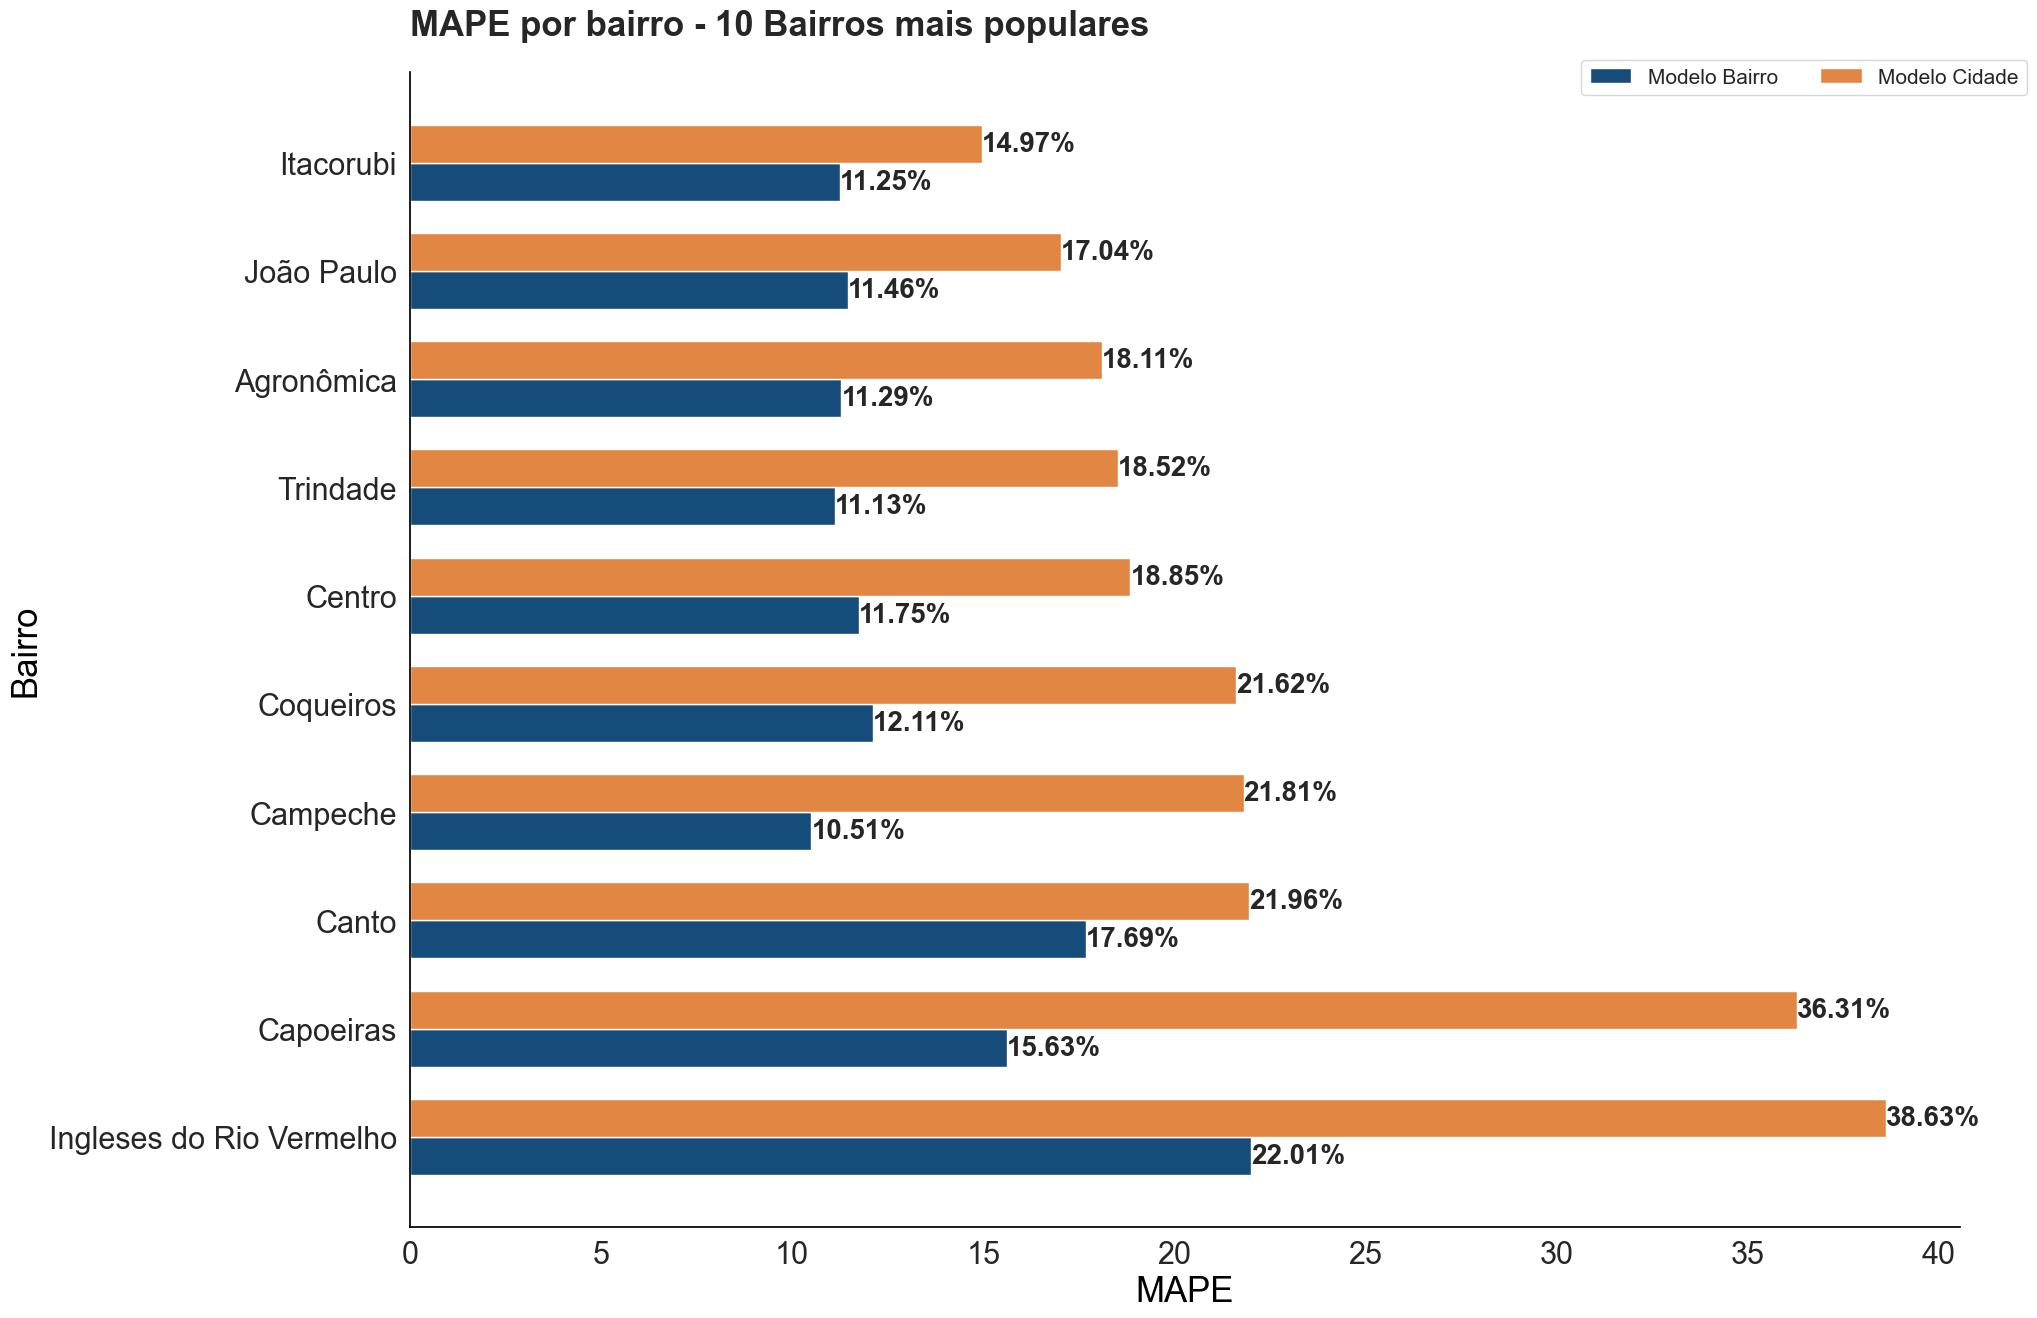

In [ ]:
sns.set_style("whitegrid", rc=style_keys)
sns.set_context("notebook", rc=context_keys)
df_todos_top_10 = df_todos_top_10.sort_values(by='MAPE', ascending=False)
# Get the neighborhoods and their corresponding index
neighborhoods = df_todos_top_10.index
index = np.arange(len(neighborhoods))
# Define the width of each bar
bar_width = 0.35

# Create the grouped horizontal bar chart
plt.figure(figsize=(20, 15))  # Adjust figure size as needed
# Plot bars for 'apartment' category
bars_isolado = plt.barh(index - bar_width, df_bairros_isolado['MAPE'], bar_width, label='Modelo Bairro', color=PALLETE[0])

# Plot bars for 'house' category
bars_todos = plt.barh(index, df_todos_top_10['MAPE'], bar_width, label='Modelo Cidade', color=PALLETE[1])

# Set labels and title
plt.xlabel('MAPE')
plt.ylabel('Bairro')
plt.title('MAPE por bairro - 10 Bairros mais populares', fontweight='bold', loc='left', y=TITLE_PAD)
plt.yticks(index - bar_width/2, neighborhoods)

# Add price values outside each bar for 'apartment' category
for i, bar_apartment in enumerate(bars_isolado):
    price_apartment = df_bairros_isolado.iloc[i]['MAPE']
    plt.text(price_apartment, i - bar_width, f'{price_apartment:.2f}%', va='center', ha='left', fontweight='bold')

# Add price values outside each bar for 'house' category
for i, bar_house in enumerate(bars_todos):
    price_house =df_todos_top_10.iloc[i]['MAPE']
    plt.text(price_house, i, f'{price_house:.2f}%', va='center', ha='left', fontweight='bold')


plt.legend(
    loc='upper right',
    bbox_to_anchor=(1.05, 1.02),
    fancybox=True,
    shadow=False,
    ncol=2
    )

os.makedirs('graphics', exist_ok=True)
plt.savefig(os.path.join('graphics', f'mape_top10_bairros.png'), bbox_inches='tight', facecolor='white')
plt.savefig(os.path.join('graphics', f'mape_top10_bairros.pdf'), bbox_inches='tight', facecolor='white')

plt.show()
#plt.close()

## Comparação do Modelo isolado x Modelo com um terço dos dados

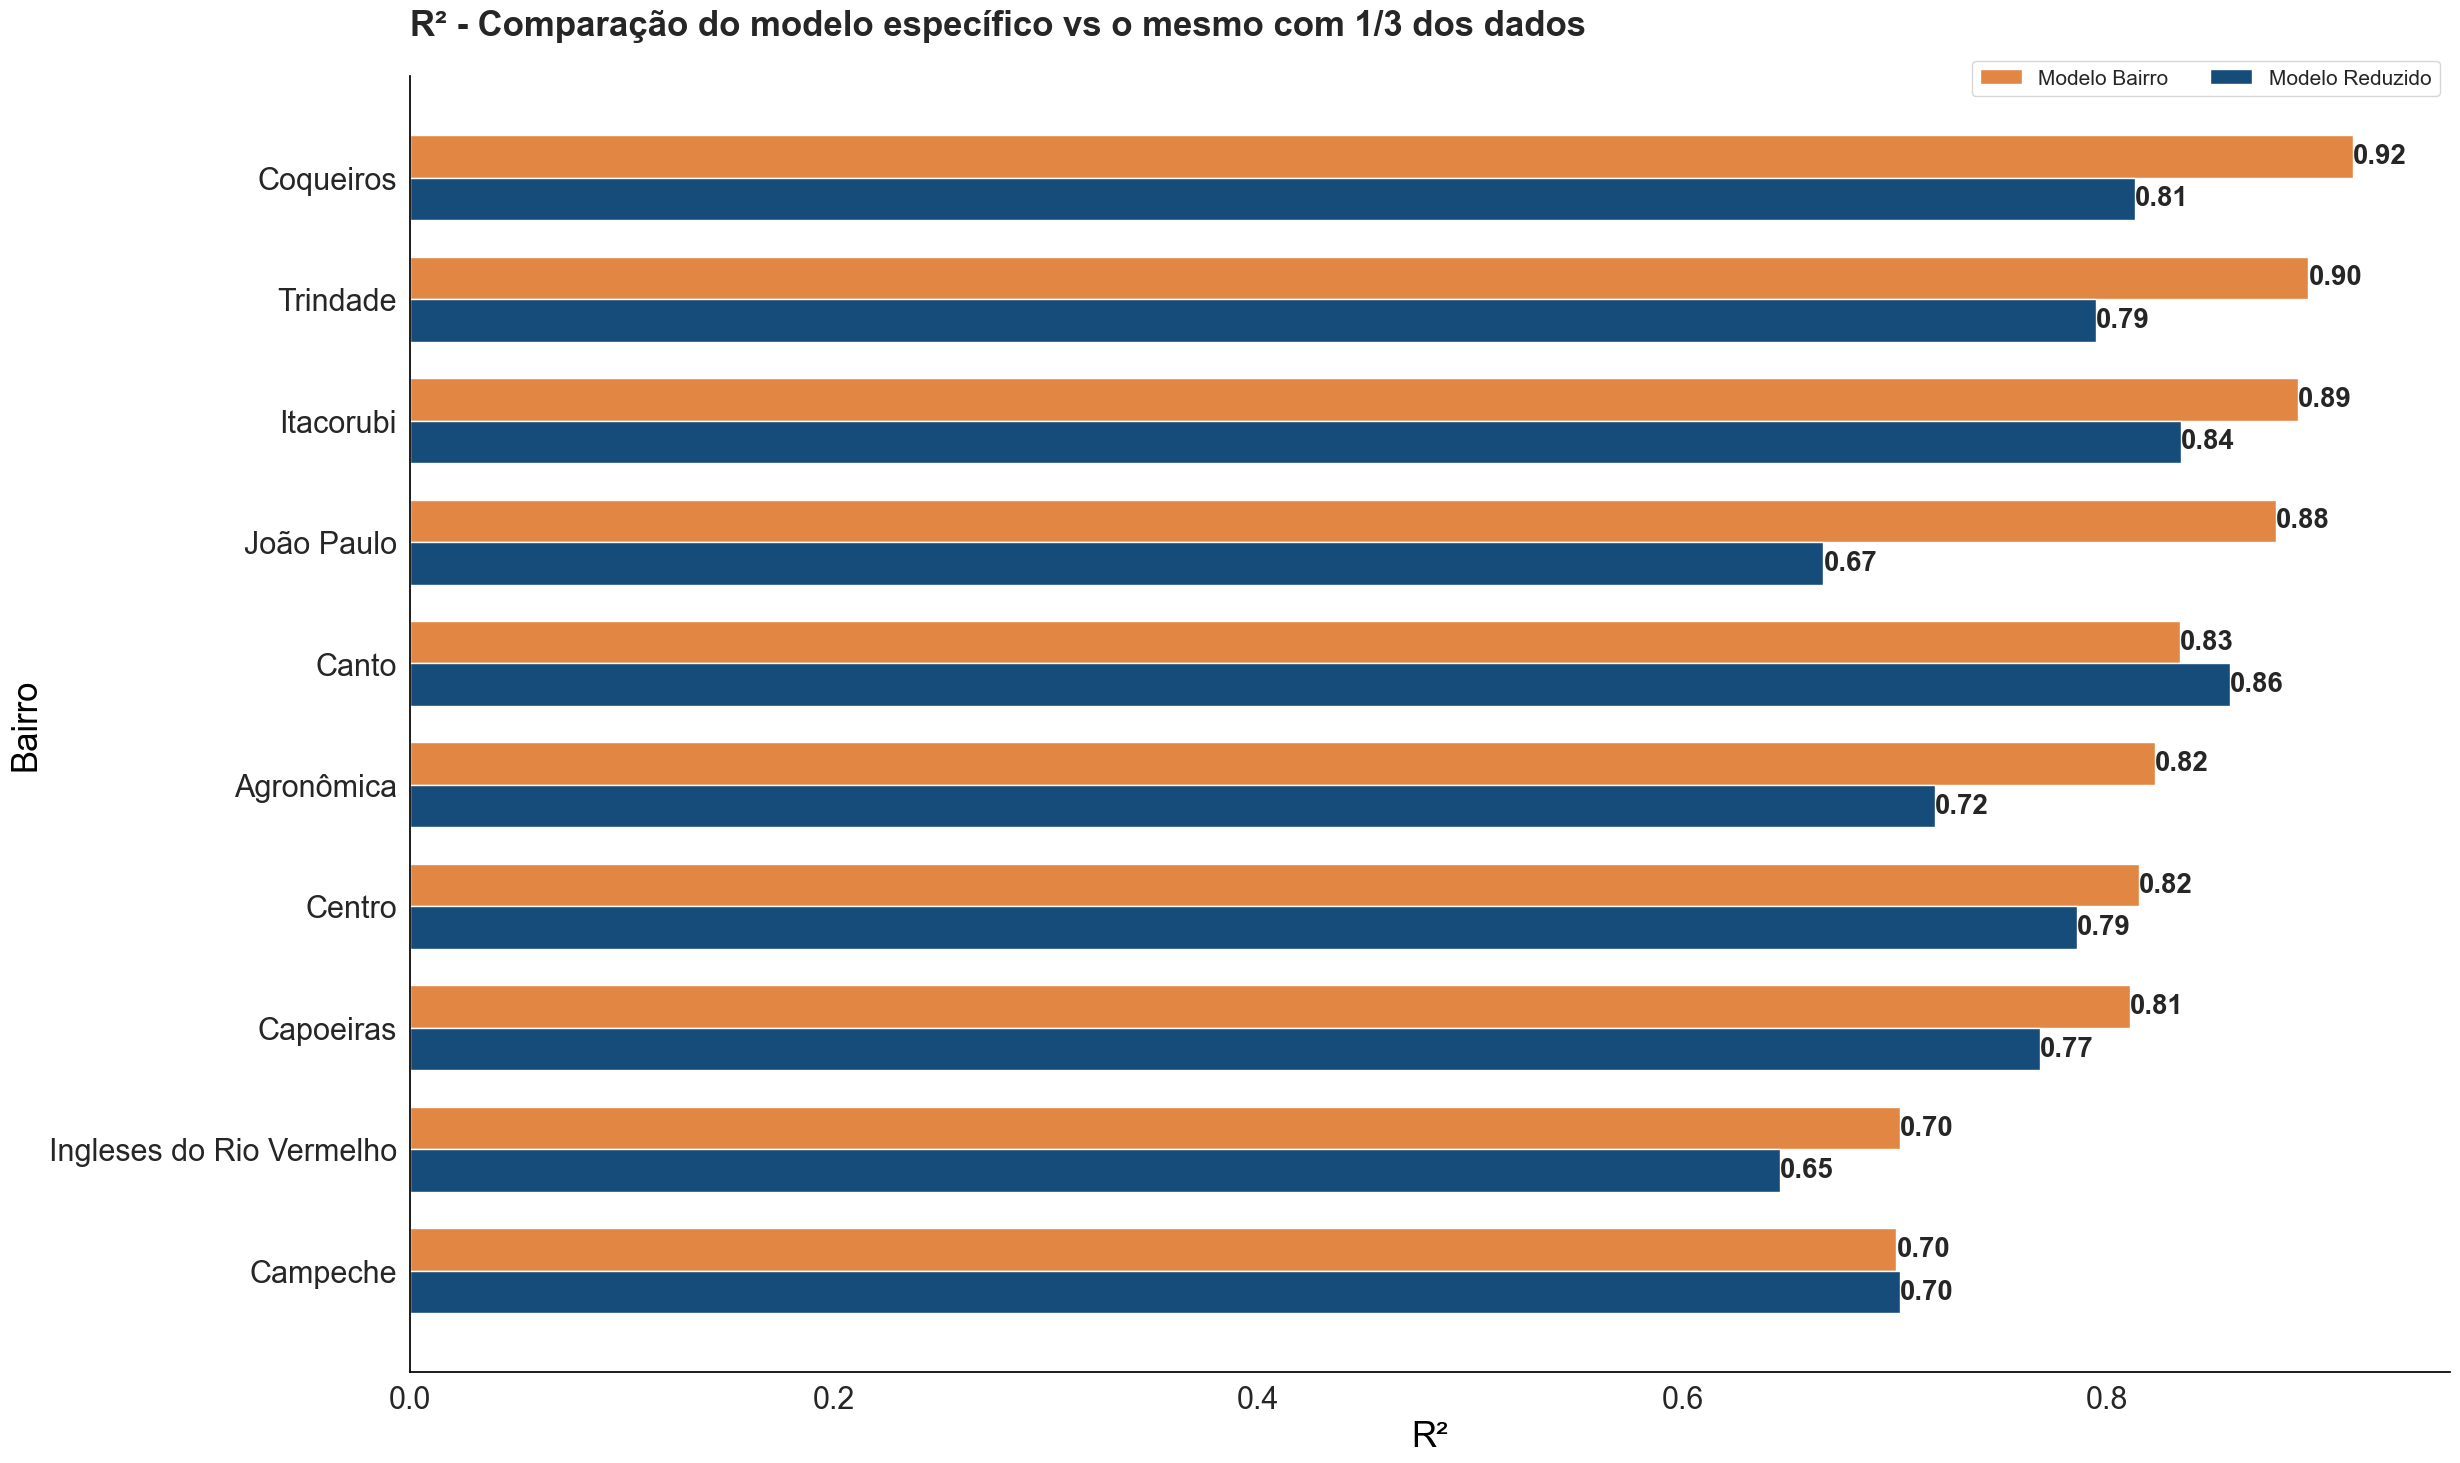

In [29]:
sns.set_style("whitegrid", rc=style_keys)
sns.set_context("notebook", rc=context_keys)
df_bairros_isolado = df_bairros_isolado.sort_values(by='R²', ascending=True)

# Get the neighborhoods and their corresponding index
neighborhoods = df_bairros_isolado.index
index = np.arange(len(neighborhoods))
# Define the width of each bar
bar_width = 0.35

# Create the grouped horizontal bar chart
plt.figure(figsize=(25, 15))  # Adjust figure size as needed

# Plot bars for 'house' category
bars_df1 = plt.barh(index, df_bairros_isolado['R²'], bar_width, label='Modelo Bairro', color=PALLETE[1])
# Plot bars for 'apartment' category
bars_df2 = plt.barh(index - bar_width, df_bairros_um_terco_media['R²'], bar_width, label='Modelo Reduzido', color=PALLETE[0])


# Set labels and title
plt.xlabel('R²')
plt.ylabel('Bairro')
plt.title('R² - Comparação do modelo específico vs o mesmo com 1/3 dos dados', fontweight='bold', loc='left', y=TITLE_PAD)
plt.yticks(index - bar_width/2, neighborhoods)

for i, bar in enumerate(bars_df1):
    value = df_bairros_um_terco_media.iloc[i]['R²']
    plt.text(value,  i - bar_width, f'{value:.2f}', va='center', ha='left', fontweight='bold')

for i, bar in enumerate(bars_df2):
    value = df_bairros_isolado.iloc[i]['R²']
    plt.text(value, i, f'{value:.2f}', va='center', ha='left', fontweight='bold')


plt.legend(
    loc='upper right',
    bbox_to_anchor=(1, 1.02),
    fancybox=True,
    shadow=False,
    ncol=2
    )

os.makedirs('graphics', exist_ok=True)
plt.savefig(os.path.join('graphics', f'r2_top10_um_terco.png'), bbox_inches='tight', facecolor='white')
plt.savefig(os.path.join('graphics', f'r2_top10_um_terco.pdf'), bbox_inches='tight', facecolor='white')

plt.tight_layout()
plt.show()
plt.close()

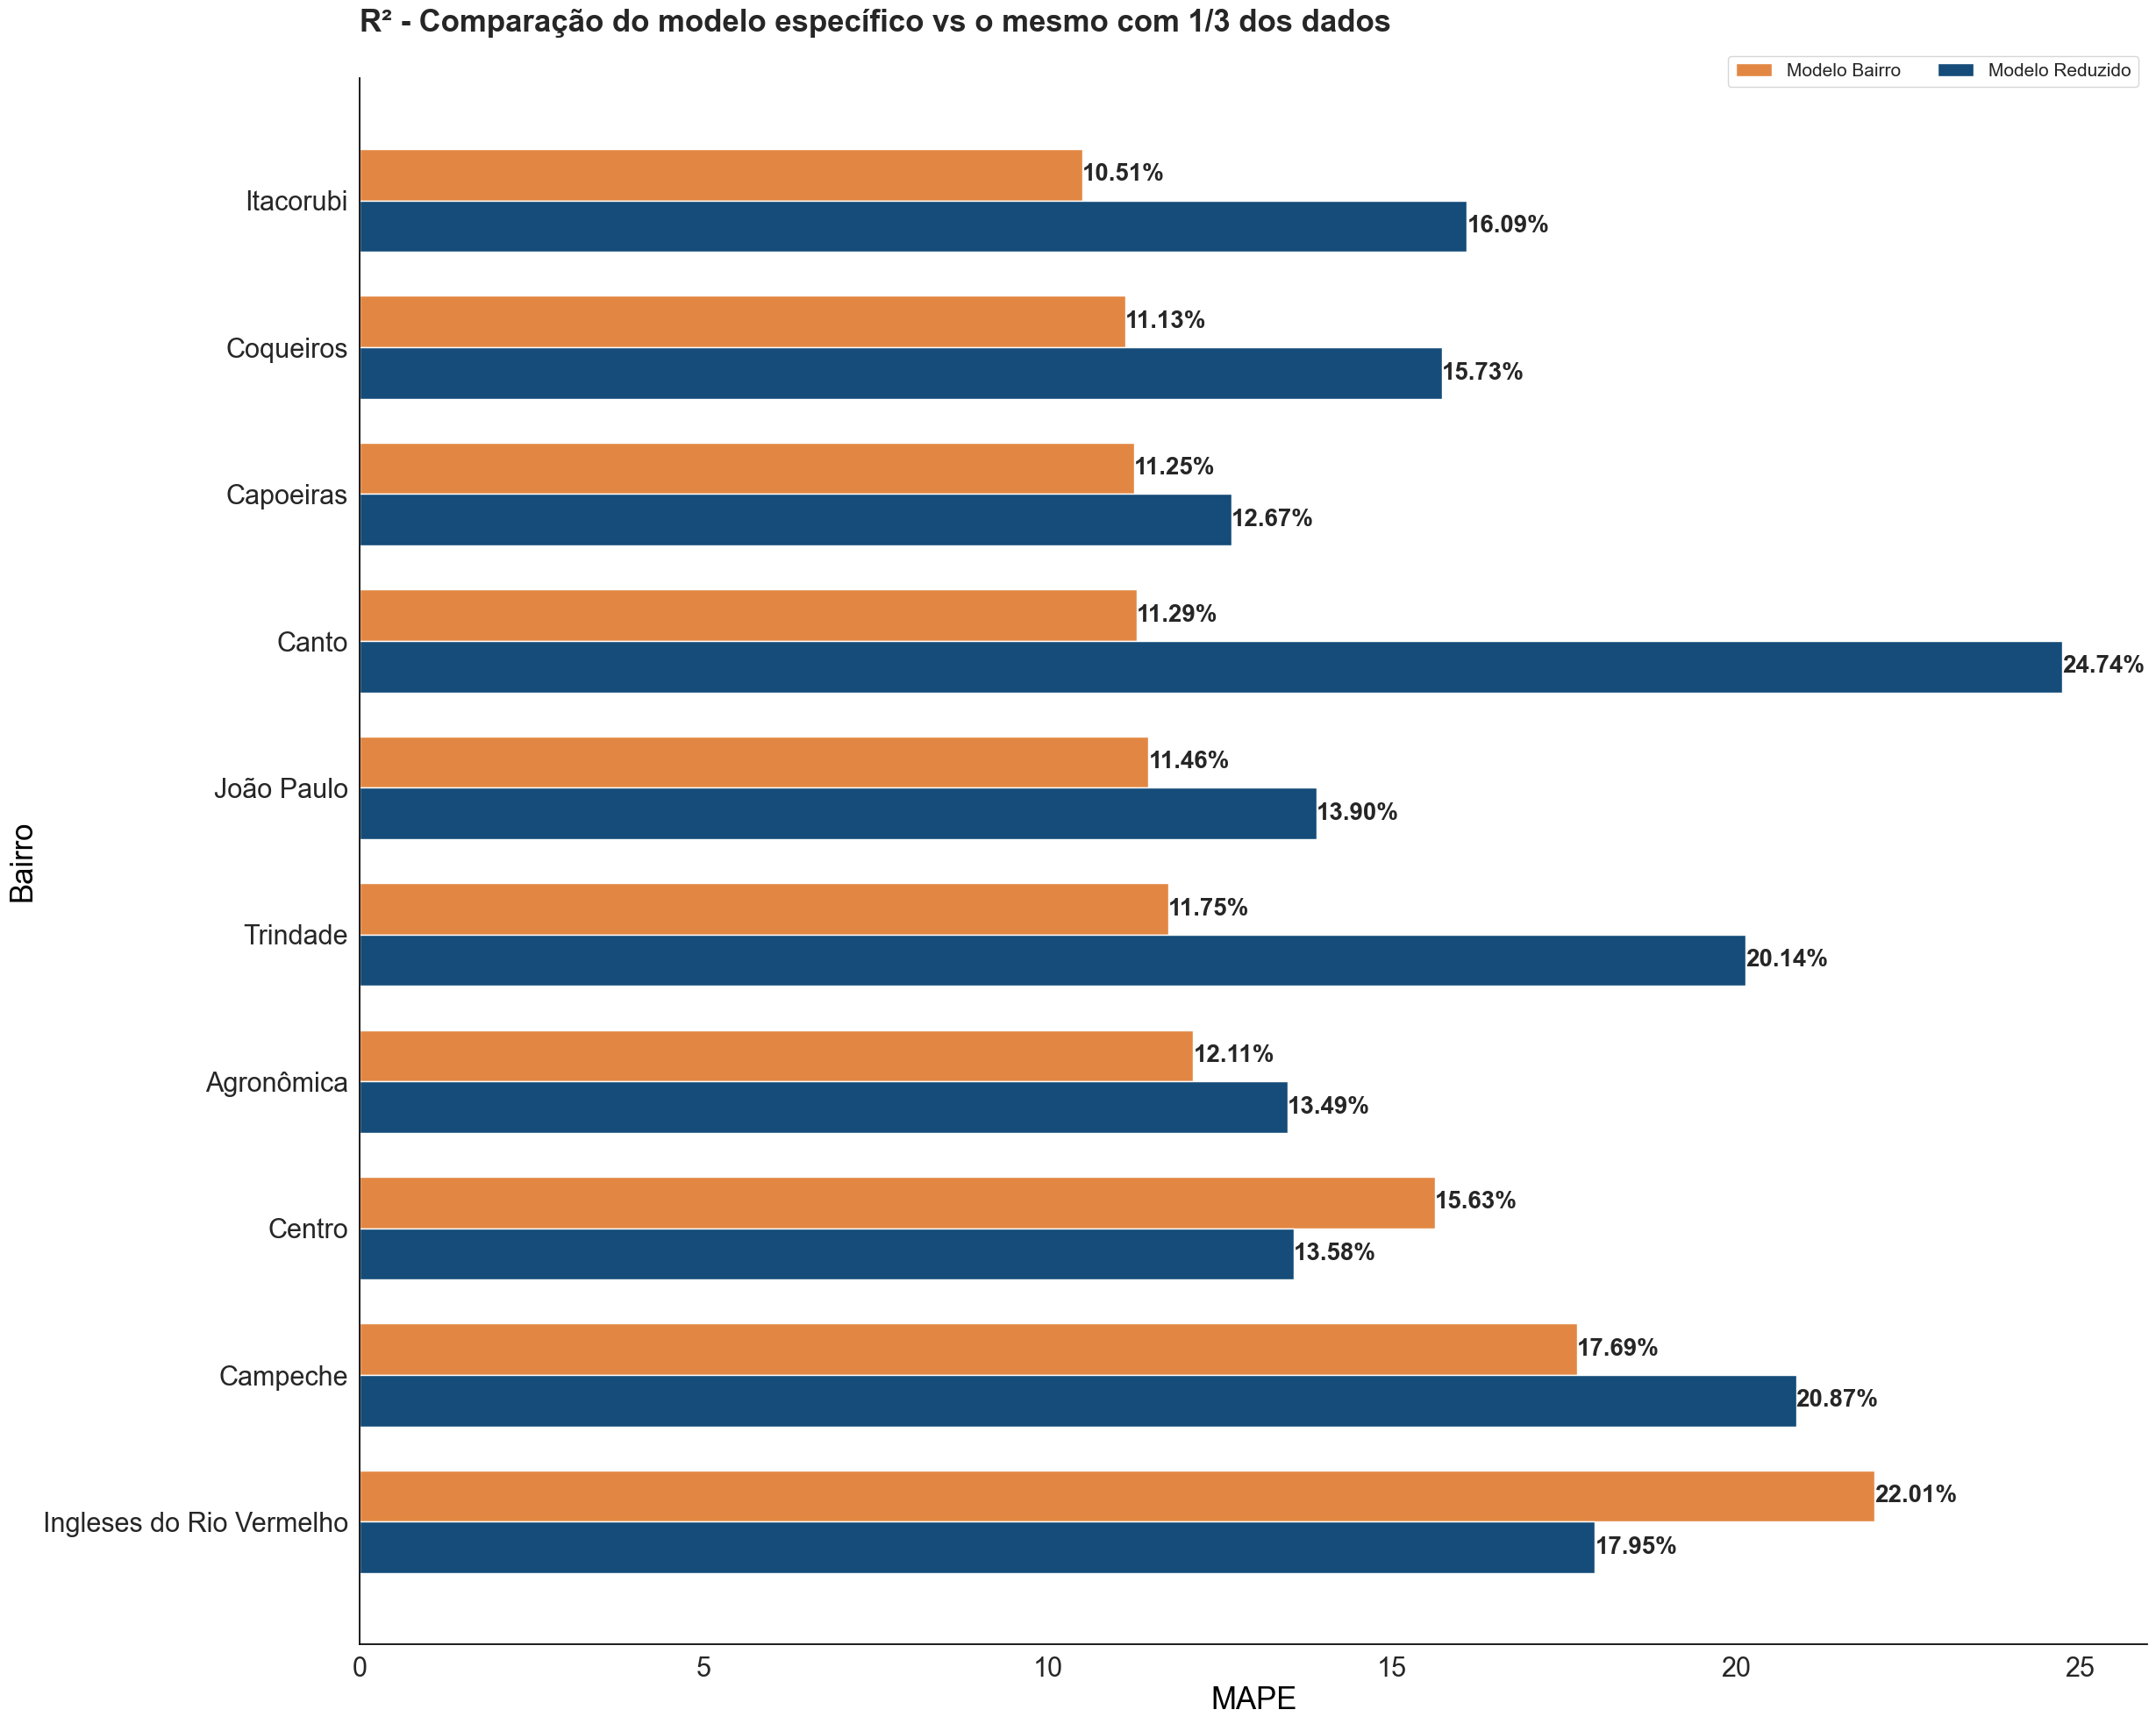

In [30]:
sns.set_style("whitegrid", rc=style_keys)
sns.set_context("notebook", rc=context_keys)
df_bairros_isolado = df_bairros_isolado.sort_values(by='MAPE', ascending=False)

# Get the neighborhoods and their corresponding index
neighborhoods = df_bairros_isolado.index
index = np.arange(len(neighborhoods))
# Define the width of each bar
bar_width = 0.35

# Create the grouped horizontal bar chart
plt.figure(figsize=(25, 20))  # Adjust figure size as needed

# Plot bars for 'house' category
bars_df1 = plt.barh(index, df_bairros_isolado['MAPE'], bar_width, label='Modelo Bairro', color=PALLETE[1])
# Plot bars for 'apartment' category
bars_df2 = plt.barh(index - bar_width, df_bairros_um_terco_media['MAPE'], bar_width, label='Modelo Reduzido', color=PALLETE[0])


# Set labels and title
plt.xlabel('MAPE')
plt.ylabel('Bairro')
plt.title('R² - Comparação do modelo específico vs o mesmo com 1/3 dos dados', fontweight='bold', loc='left', y=TITLE_PAD)
plt.yticks(index - bar_width/2, neighborhoods)

for i, bar in enumerate(bars_df1):
    value = df_bairros_um_terco_media.iloc[i]['MAPE']
    plt.text(value,  i - bar_width, f'{value:.2f}%', va='center', ha='left', fontweight='bold')

for i, bar in enumerate(bars_df2):
    value = df_bairros_isolado.iloc[i]['MAPE']
    plt.text(value, i, f'{value:.2f}%', va='center', ha='left', fontweight='bold')


plt.legend(
    loc='upper right',
    bbox_to_anchor=(1, 1.02),
    fancybox=True,
    shadow=False,
    ncol=2
    )

os.makedirs('graphics', exist_ok=True)
plt.savefig(os.path.join('graphics', f'mape_top10_um_terco.png'), bbox_inches='tight', facecolor='white')
plt.savefig(os.path.join('graphics', f'mape_top10_um_terco.pdf'), bbox_inches='tight', facecolor='white')

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Função para adicionar texto sobre as barras
def add_text_labels(ax, values):
    for i, value in enumerate(values):
        ax.text(i, value, f'{value:.2f}', ha='center', va='bottom', weight='bold')

# Selecting the experiments for plotting
selected_experiments = [ 'Todos', 'Área_com_amenidades', 'Banheiro_com_amenidades', 'Quartos_com_amenidades', 
                        'Garagem_com_amenidades', 'Suits_com_amenidades', 'Amenidades',]

# Extracting R² and MAPE values for the selected experiments
r_squared_values = [experiment_results[experiment]['R²'] for experiment in selected_experiments]
mape_values = [experiment_results[experiment]['MAPE'] for experiment in selected_experiments]


# Criando o gráfico de barras para R²
plt.figure(figsize=(30, 20))
ax1 = sns.barplot(x=selected_experiments, y=r_squared_values, color=COR_AZUL)
plt.title('R² por experimento', fontweight='bold', loc='left', y=ALTURA_TITULO)  # Ajuste o parâmetro y para adicionar espaço

plt.xlabel('Experimento')
plt.ylabel('R²')
plt.xticks(rotation=45, ha='right')

# Adicionando texto sobre as barras
add_text_labels(ax1, r_squared_values)

plt.tight_layout()
plt.savefig('graphics/r2_per_experiment.pdf', bbox_inches='tight', format='pdf', dpi=DPI)                                          
plt.show()

# Criando o gráfico de barras para MAPE
plt.figure(figsize=(30, 20))
ax2 = sns.barplot(x=selected_experiments, y=mape_values, color=COR_AZUL)
plt.title('MAPE por experimento', fontweight='bold', loc='left', y=ALTURA_TITULO)  # Ajuste o parâmetro y para adicionar espaço
plt.xlabel('Experimento')
plt.ylabel('MAPE')
plt.xticks(rotation=45, ha='right')

# Adicionando texto sobre as barras
add_text_labels(ax2, mape_values)

plt.tight_layout()
plt.savefig('graphics/mape_per_experiment.pdf', bbox_inches='tight', format='pdf', dpi=DPI)                                          
plt.show()


NameError: name 'experiment_results' is not defined